# Class 7 - 22.4.18

# Advanced Pandas

## Missing Data

The last question in the previous class pointed us to working with missing data. But how and why does missing data occur?

One option is pandas' index alignment, the property that makes sure that each value will have the same index throughout the entire computation process.

In [99]:
import pandas as pd
import numpy as np


A = pd.Series([2, 4, 6], index=[0, 1, 2])
B = pd.Series([1, 3, 5], index=[1, 2, 3])
A + B

0    NaN
1    5.0
2    9.0
3    NaN
dtype: float64

The NaNs we have are what we call missing data - this is the way pandas represents it. We'll discuss about it in detail in a few slides.

The same thing occurs with dataframes:

In [100]:
A = pd.DataFrame(np.random.randint(0, 20, (2, 2)),
                 columns=list('AB'))
A

,A,B
0,18,2
1,16,6


In [101]:
B = pd.DataFrame(np.random.randint(0, 10, (3, 3)),
                 columns=list('BAC'))
B

,B,A,C
0,4,5,6
1,8,3,1
2,4,6,0


In [102]:
A + B

,A,B,C
0,23.0,6.0,NaN
1,19.0,14.0,NaN
2,NaN,NaN,NaN


The DF's shape is the shape of the larger DF, and the "extra" row (index 2) was filled with NaNs. Since we have NaNs, the data type of the column is implicitly converted to a floating point type. Python doesn't have integer NaNs.

Another way to introduce missing data is through reindexing. If we "resample" our data we can achieve the following:

In [103]:
df = pd.DataFrame(np.random.randn(5, 3), index=['a', 'c', 'e', 'f', 'h'],
                  columns=['one', 'two', 'three'])
df

,one,two,three
a,0.023782,1.619193,-0.768613
c,2.118173,0.209990,-0.488485
e,-1.598272,0.544843,0.469744
f,0.029426,0.591125,1.147687
h,-0.523579,-0.502243,0.172872


In [104]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three
a,0.023782,1.619193,-0.768613
b,NaN,NaN,NaN
c,2.118173,0.209990,-0.488485
d,NaN,NaN,NaN
e,-1.598272,0.544843,0.469744
f,0.029426,0.591125,1.147687
g,NaN,NaN,NaN
h,-0.523579,-0.502243,0.172872


As we mentioned, pandas is oriented towards handling missing data. In general one finds two approaches that one can take - either create a masking array around the DF, in which `False` values represent invalid entries, or create a _sentinel_ value that represents missing data, like -99999 or NaN.

These two approaches have their downsides - a boolean masks requires more memory, and perhaps longer computation times. The sentinel value might lead to use of inefficient data types and slow down computation as well.

Due to its reliance on numpy, pandas chose the path of sentinel values, with either `None` or NaN as the value.

### The `None` object

While `None` can be used as a missing data type, it's probably not the best choice.

In [105]:
vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

The `dtype` is `object`, because the best common type of `int`s and a `None` is a Python `object`. This slows down computation time on these arrays:

In [106]:
for dtype in ['object', 'int']:
    print("dtype =", dtype)
    %timeit np.arange(1E6, dtype=dtype).sum()
    print()

dtype = object
131 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

dtype = int
5.95 ms ± 660 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



Another thing we can't do is aggregation:

In [107]:
vals1.sum()

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

### The `NaN` value

`NaN` is a special floating-point value recognized by all programming languages that conform to the IEEE standard (which means most of them). As we mentioned before, it forces the entire array to have a floating point type:

In [108]:
vals2 = np.array([1, np.nan, 3, 4])
vals2.dtype

dtype('float64')

Creating floating point arrays is very fast, so performance isn't hindered. NaN is sometimes described as a "data virus", since it infects objects it touches:

In [109]:
1 + np.nan

nan

In [110]:
0 * np.nan

nan

In [111]:
vals2.sum(), vals2.min(), vals2.max()  # runtime warnings, not exceptions

C:\Users\Hagai\Miniconda3\envs\general\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Hagai\Miniconda3\envs\general\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


(nan, nan, nan)

However, pandas objects account for NaNs in their calculations, as we'll soon see.

pandas can handle both `NaN` and `None` interchangeably:

In [112]:
ser = pd.Series([1, np.nan, 2, None])
ser

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

### The `NaT` value

When dealing with datetime values or indices, the missing value is represented as `NaT`, or not-a-time:

In [113]:
df['timestamp'] = pd.Timestamp('20180101')
df

,one,two,three,timestamp
a,0.023782,1.619193,-0.768613,2018-01-01
c,2.118173,0.209990,-0.488485,2018-01-01
e,-1.598272,0.544843,0.469744,2018-01-01
f,0.029426,0.591125,1.147687,2018-01-01
h,-0.523579,-0.502243,0.172872,2018-01-01


In [114]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three,timestamp
a,0.023782,1.619193,-0.768613,2018-01-01
b,NaN,NaN,NaN,NaT
c,2.118173,0.209990,-0.488485,2018-01-01
d,NaN,NaN,NaN,NaT
e,-1.598272,0.544843,0.469744,2018-01-01
f,0.029426,0.591125,1.147687,2018-01-01
g,NaN,NaN,NaN,NaT
h,-0.523579,-0.502243,0.172872,2018-01-01


### Operations and calculations with missing data

In [115]:
a = pd.DataFrame(np.random.random((5, 2)), columns=['one', 'two'])
a.iloc[1, 1] = np.nan
a

,one,two
0,0.870333,0.186277
1,0.127492,NaN
2,0.396787,0.784549
3,0.999524,0.116718
4,0.799341,0.642912


In [116]:
b = pd.DataFrame(np.random.random((6, 3)), columns=['one', 'two', 'three'])
b.iloc[2, 2] = np.nan
b

,one,two,three
0,0.320026,0.600920,0.566103
1,0.654437,0.238786,0.403075
2,0.134890,0.158237,NaN
3,0.289947,0.679237,0.733771
4,0.377597,0.813411,0.104845
5,0.898095,0.170077,0.486180


In [117]:
a + b

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,NaN
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,1.176938,NaN,1.456323
5,NaN,NaN,NaN


As we see, missing values propagate naturally through these arithmetic operations. Statistics also works:

In [118]:
(a + b).describe()
# Summation - NaNs are zero.
# If everything is NaN - the result is NaN as well.
# pandas' cumsum and cumprod ignore NaNs but preserve them in the resulting arrays.

,one,three,two
count,5.000000,0.0,4.000000
mean,0.994074,NaN,0.995565
std,0.323281,NaN,0.315354
min,0.531676,NaN,0.787197
25%,0.781929,NaN,0.793765
50%,1.176938,NaN,0.869370
75%,1.190358,NaN,1.071170
max,1.289471,NaN,1.456323


We can also receive a boolean mask of the NaNs in a dataframe:

In [119]:
mask = (a + b).isnull()

#### Filling missing values

The simplest option is to use the `fillna` method:

In [120]:
summed = a + b
summed.iloc[4, 0] = np.nan
summed

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,NaN
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,NaN,NaN,1.456323
5,NaN,NaN,NaN


In [121]:
summed.fillna(0)

,one,three,two
0,1.190358,0.0,0.787197
1,0.781929,0.0,0.000000
2,0.531676,0.0,0.942786
3,1.289471,0.0,0.795955
4,0.000000,0.0,1.456323
5,0.000000,0.0,0.000000


In [122]:
summed.fillna('missing')  # changed dtype to "object"

,one,three,two
0,1.19036,missing,0.787197
1,0.781929,missing,missing
2,0.531676,missing,0.942786
3,1.28947,missing,0.795955
4,missing,missing,1.45632
5,missing,missing,missing


In [123]:
summed.fillna(method='pad')  # The NaN column remained the same, but values were propagated forward
# We can also use the "backfill" method to fill in values to the back

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,0.787197
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,1.289471,NaN,1.456323
5,1.289471,NaN,1.456323


In [124]:
summed.fillna(method='pad', limit=1)  # No more than one padded NaN in a row

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,0.787197
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,1.289471,NaN,1.456323
5,NaN,NaN,1.456323


In [125]:
summed.fillna(summed.mean())  # each column received its respective mean. The NaN column is untouched.

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,0.995565
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,0.948359,NaN,1.456323
5,0.948359,NaN,0.995565


#### Dropping missing values

We've already seen in the short exercise the `dropna` method, that allows us to drop missing values:

In [126]:
summed

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,NaN
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,NaN,NaN,1.456323
5,NaN,NaN,NaN


In [127]:
filled = summed.fillna(summed.mean())
filled

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,0.995565
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,0.948359,NaN,1.456323
5,0.948359,NaN,0.995565


In [128]:
filled.dropna(axis=1)  # each column containing NaN is dropped

,one,two
0,1.190358,0.787197
1,0.781929,0.995565
2,0.531676,0.942786
3,1.289471,0.795955
4,0.948359,1.456323
5,0.948359,0.995565


In [129]:
filled.dropna(axis=0)  # each row containing a NaN is dropped

,one,three,two


#### Interpolation

The last way to to fill in missing values is through interpolation.

The default interpolation methods perform linear interpolation on the data, based on its ordinal index:

In [130]:
summed

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,NaN
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,NaN,NaN,1.456323
5,NaN,NaN,NaN


In [131]:
summed.interpolate()  # notice all the details in the interpolation of the three columns

,one,three,two
0,1.190358,NaN,0.787197
1,0.781929,NaN,0.864991
2,0.531676,NaN,0.942786
3,1.289471,NaN,0.795955
4,1.289471,NaN,1.456323
5,1.289471,NaN,1.456323


We can also interpolate with the actual index values in mind:

In [132]:
# Create "missing" index
timeindex = pd.Series(['1/1/2018', '1/4/2018', '1/5/2018', '1/7/2018', '1/8/2018'])
timeindex = pd.to_datetime(timeindex)
data_to_interp = [1, np.nan, 5, np.nan, 8]
df_to_interp = pd.DataFrame(data_to_interp, index=timeindex)
df_to_interp

,0
2018-01-01,1.0
2018-01-04,NaN
2018-01-05,5.0
2018-01-07,NaN
2018-01-08,8.0


In [133]:
df_to_interp.interpolate()  # the index values aren't taken into account

,0
2018-01-01,1.0
2018-01-04,3.0
2018-01-05,5.0
2018-01-07,6.5
2018-01-08,8.0


In [134]:
df_to_interp.interpolate(method='index')  # notice how the data obtains the "right" values

,0
2018-01-01,1.0
2018-01-04,4.0
2018-01-05,5.0
2018-01-07,7.0
2018-01-08,8.0


Pandas has many other interpolation methods, based on SciPy's. 

In [135]:
df_inter_2 = pd.DataFrame({'A': [1, 2.1, np.nan, 4.7, 5.6, 6.8],
                           'B': [.25, np.nan, np.nan, 4, 12.2, 14.4]})
df_inter_2

,A,B
0,1.0,0.25
1,2.1,NaN
2,NaN,NaN
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [136]:
df_inter_2.interpolate(method='polynomial', order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-2.703846
2,3.451351,-1.453846
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


## Hierarchical Indexing

Last time we mentioned that while a DataFrame is inherently a 2D object, it can contain multi-dimensional data. The way a DataFrame (and a Series) does that is with Hierarchical Indexing, sometimes Multi-Indexing.

After the deprecation of `pd.Panel`, this is the only remaining way to represent data of higher dimensions in pandas, making it a very useful tool for data science.

### Simple Example

Let's assume I wish to represent points on a 2D grid, perhaps inside a square, that represent the temperature in different locations around this grid. The obvious way to do this is to define a set of two coordinates, $(x, y)$, which point to a specific location inside my square. These two coordinates should also have a value attached to them - the temperature. A list of such coordinates can be a simple Series:

In [137]:
values = np.array([1.2, 0.8, 3.1, 0.1, 0.05, 1, 1.4, 2.1, 2.9])
coords = [('r0', 'c0'), ('r0', 'c1'), ('r0', 'c2'), 
          ('r1', 'c0'), ('r1', 'c1'), ('r1', 'c2'), 
          ('r2', 'c0'), ('r2', 'c1'), ('r2', 'c2')]  # r is row, c is column
points = pd.Series(values, index=coords, name='temperature')
points

(r0, c0)    1.20
(r0, c1)    0.80
(r0, c2)    3.10
(r1, c0)    0.10
(r1, c1)    0.05
(r1, c2)    1.00
(r2, c0)    1.40
(r2, c1)    2.10
(r2, c2)    2.90
Name: temperature, dtype: float64

It is important we understand that this is a series because _the data is one-dimensional_. The actual data is contained in `values`, a one-dimensional array. We do have two coordinates for each point, but the data itself is one-dimensional.

Pandas can help us to index this data in a more intuitive manner, using a MultiIndex object.

In [138]:
mindex = pd.MultiIndex.from_tuples(coords)
mindex

MultiIndex(levels=[['r0', 'r1', 'r2'], ['c0', 'c1', 'c2']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]])

Let's examine this object carefully. 

`levels` is a nested list containing the different options for the index. Each level of the index is a single (list), and the fact that we have two lists means that our index has a level of 2. A regular index has a level of 1.

`labels` is the specific ordering of the data with respect to the `levels`. It's how our data is organized. Each list in `labels` has the length of the entire index, and its values represent the labels of that index, as written in `levels`.

It's easier to understand if we just examine the data. Let's `reindex` our data:

In [139]:
points = points.reindex(mindex)
points

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

This looks good. Each index level is represented by a column, with the data being the last one. The "missing" values indicate that the value in that cell is the same as the value above it.

You might have assumed that accessing the data now is much more intuitive. Let's look at the values of all the points in the first row, `r0`:

In [140]:
points.loc['r0', :]

r0  c0    1.2
    c1    0.8
    c2    3.1
Name: temperature, dtype: float64

Or the values of points in the second column:

In [141]:
points.loc[:, 'c1']

r0    0.80
r1    0.05
r2    2.10
Name: temperature, dtype: float64

Notice that `.iloc` in this case disregarding the MultiIndex, treating our data as a simple one-dimensional vector:

In [142]:
points.iloc[6]
# points.iloc[0, 1]  # ERRORS

1.4

Besides making the syntax cleaner, these slicing operations are as efficient as their single-dimension counterparts.

It should be clear that a MultiIndex can have more than two levels. Modelling a 3D cube (with the temperatures inside it) is as easy as:

In [143]:
values3d = np.array([1.2, 0.8, 
                   3.1, 0.1, 
                   0.05, 1, 
                   1.4, 2.1, 
                   2.9, 0.3,
                   2.4, 1.9])
coords3d = [('r0', 'c0', 'z0'), ('r0', 'c0', 'z1'), 
            ('r0', 'c1', 'z0'), ('r0', 'c1', 'z1'),
            ('r1', 'c0', 'z0'), ('r1', 'c0', 'z1'),
            ('r1', 'c1', 'z0'), ('r1', 'c1', 'z1'), 
            ('r2', 'c0', 'z0'), ('r2', 'c0', 'z1'),
            ('r2', 'c1', 'z0'), ('r2', 'c1', 'z1')]  # we'll soon see an easier way to create this index
cube = pd.Series(values3d, index=pd.MultiIndex.from_tuples(coords3d), name='cube')
cube

r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: cube, dtype: float64

We can even name the individual levels, which helps with some slicing operations we'll see below:

In [144]:
cube.index.names = ['x', 'y', 'z']
cube

x   y   z 
r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: cube, dtype: float64

Again, you have to remember that this is one-dimensional data, with a three-dimensional index. In statistical term, we might term the indices a fixed, independent categorical variable, while the values are the dependent variable. Pandas actually has a `CategoricalIndex` object which you'll meet in your HW.

### More on extra dimensions

In the previous square example, it's very appealing to ditch the MultiIndex altogether and just work with a DataFrame, or even a simple numpy array. This is because the two indices represented rows and columns. A quick way to turn one representation into the other is the `stack()`\\`unstack()` method:

In [145]:
points

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

In [146]:
pts_df = points.unstack()
pts_df

,c0,c1,c2
r0,1.2,0.80,3.1
r1,0.1,0.05,1.0
r2,1.4,2.10,2.9


In [147]:
pts_df.stack()  # back to a series

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
dtype: float64

So why bother with these (you haven't seen nothing yet) complicated multi-indices?

As you might have guessed, adding data points, i.e. increasing the dimensionality of the data, is very easy and intuitive. Data remains aligned through addition and deletion of data. Moreover, treating these categorical variables as an index can help the mental modeling of the problem, especially when you wish to perform statistical modeling with your analysis.

If you're not convinced yet, I'm sure that in a couple of examples you'll see their true power unfold.

### Constructing a MultiIndex

Creating a hierarchical index can be done in several ways:

In [148]:
pd.MultiIndex.from_arrays([['a', 'a', 'b', 'b'], [1, 2, 1, 2]])

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In [149]:
pd.MultiIndex.from_tuples([('a', 1), ('a', 2), ('b', 1), ('b', 2)])

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In [150]:
pd.MultiIndex.from_product([['a', 'b'], [1, 2]])  # Cartesian product

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

The most common way to construct a MultiIndex, though, is to add to the existing index one of the columns of the DataFrame. We'll see how it's done below.

Another important note is that with DataFrames, the column and row index is symmetric. In effect this means that  the columns could also contain a MultiIndex:

In [151]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2]],
                                   names=['year', 'visit'])
columns = pd.MultiIndex.from_product([['Bob', 'Guido', 'Sue'], ['HR', 'Temp']],
                                     names=['subject', 'type'])

# mock some data
data = np.round(np.random.randn(4, 6), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data = pd.DataFrame(data, index=index, columns=columns)
health_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      41.0  36.7  48.0  37.4  43.0  35.7
     2      30.0  37.1  37.0  36.4  32.0  36.8
2014 1      31.0  37.4  37.0  38.0  32.0  36.8
     2      41.0  36.2  43.0  36.8  29.0  36.2

This sometimes might seem too much, and so usually people prefer to keep the column index as a simple list of names, moving any nestedness to the row index. This is due to the fact that usually columns represent the measured dependent variable.

In [152]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2], ['Bob', 'Guido', 'Sue']],
                                   names=['year', 'visit', 'subject'])
columns = ['HR', 'Temp']

# mock some data
data = np.round(np.random.randn(12, 2), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data_row = pd.DataFrame(data, index=index, columns=columns)
health_data_row

HR  Temp
year visit subject            
2013 1     Bob      37.0  36.6
           Guido    40.0  37.9
           Sue      49.0  36.9
     2     Bob      45.0  37.5
           Guido    43.0  36.1
           Sue      28.0  36.5
2014 1     Bob      39.0  37.6
           Guido    36.0  36.0
           Sue      42.0  37.2
     2     Bob      43.0  35.3
           Guido    30.0  36.1
           Sue      15.0  35.5

#### Creating a MultiIndex from a data column

While all of the above methods work, and could be useful sometimes, the most common method of creating an index is from an existing data column. 

In [153]:
location = ['AL', 'AL', 'NY', 'NY', 'NY', 'VA']
day = ['SUN', 'SUN', 'TUE', 'WED', 'SAT', 'SAT']
temp = [12.3, 14.1, 21.3, 20.9, 18.8, 16.5]
humidity = [31, 45, 41, 41, 49, 52]
states = pd.DataFrame(dict(location=location, day=day, 
                           temp=temp, humidity=humidity))
states

,day,humidity,location,temp
0,SUN,31,AL,12.3
1,SUN,45,AL,14.1
2,TUE,41,NY,21.3
3,WED,41,NY,20.9
4,SAT,49,NY,18.8
5,SAT,52,VA,16.5


In [154]:
states.set_index(['day'])

,humidity,location,temp
day,,,
SUN,31,AL,12.3
SUN,45,AL,14.1
TUE,41,NY,21.3
WED,41,NY,20.9
SAT,49,NY,18.8
SAT,52,VA,16.5


In [155]:
states.set_index(['day', 'location'])

humidity  temp
day location                
SUN AL              31  12.3
    AL              45  14.1
TUE NY              41  21.3
WED NY              41  20.9
SAT NY              49  18.8
    VA              52  16.5

In [156]:
states.set_index(['day', 'location'], append=True)

,,,humidity,temp
,day,location,,
0,SUN,AL,31,12.3
1,SUN,AL,45,14.1
2,TUE,NY,41,21.3
3,WED,NY,41,20.9
4,SAT,NY,49,18.8
5,SAT,VA,52,16.5


In [157]:
states.set_index([['i', 'ii', 'iii', 'iv', 'v', 'vi'], 'day'])

,,humidity,location,temp
,day,,,
i,SUN,31,AL,12.3
ii,SUN,45,AL,14.1
iii,TUE,41,NY,21.3
iv,WED,41,NY,20.9
v,SAT,49,NY,18.8
vi,SAT,52,VA,16.5


### Indexing and Slicing a MultiIndex

If all we wish to do is to examine a column, indexing is very easy. Don't forget the DataFrame as dictionary analogy:

In [158]:
health_data_row['HR']  # that's a Series!

year  visit  subject
2013  1      Bob        37.0
             Guido      40.0
             Sue        49.0
      2      Bob        45.0
             Guido      43.0
             Sue        28.0
2014  1      Bob        39.0
             Guido      36.0
             Sue        42.0
      2      Bob        43.0
             Guido      30.0
             Sue        15.0
Name: HR, dtype: float64

In [159]:
health_data['Guido']  # works for the column MultiIndex as expected

type          HR  Temp
year visit            
2013 1      48.0  37.4
     2      37.0  36.4
2014 1      37.0  38.0
     2      43.0  36.8

In [160]:
# Accessing single elements is also pretty straight-forward
health_data_row.loc[2013, 1, 'Guido']  # index triplet

HR      40.0
Temp    37.9
Name: (2013, 1, Guido), dtype: float64

In [161]:
# We can even slice easily using the first MultiIndex (year in our case)
health_data_row.loc[2013:2017]  # 2017 doesn't exist, but Python's slicing rules prevent an exception here
# health_data_row.loc[1]  # doesn't work

HR  Temp
year visit subject            
2013 1     Bob      37.0  36.6
           Guido    40.0  37.9
           Sue      49.0  36.9
     2     Bob      45.0  37.5
           Guido    43.0  36.1
           Sue      28.0  36.5
2014 1     Bob      39.0  37.6
           Guido    36.0  36.0
           Sue      42.0  37.2
     2     Bob      43.0  35.3
           Guido    30.0  36.1
           Sue      15.0  35.5

Slicing is a bit more difficult when we want to take into account all available indices. This is due to the possible conflicts between the different indices and the columns.

Assuming we want to look at all the years, with all the visits, only by Bob - we would want to write something like this:

In [162]:
# health_data_row.loc[(:, :, 'Bob'), :]  # doesn't work

This pickle is solved in two possible ways:

In [163]:
# First option - the slice object
row_idx = (slice(None), slice(None), 'Bob')  # all years, all visits, of Bob
health_data_row.loc[row_idx, 'HR']
# arr[slice(None), 1] is the same as arr[:, 1]

year  visit  subject
2013  1      Bob        37.0
      2      Bob        45.0
2014  1      Bob        39.0
      2      Bob        43.0
Name: HR, dtype: float64

In [164]:
# First option - the slice object
row_idx = (slice(None), slice(None), slice('Bob', 'Guido'))  # all years, all visits, Bob + Guido
health_data_row.loc[row_idx, 'HR']

year  visit  subject
2013  1      Bob        37.0
             Guido      40.0
      2      Bob        45.0
             Guido      43.0
2014  1      Bob        39.0
             Guido      36.0
      2      Bob        43.0
             Guido      30.0
Name: HR, dtype: float64

In [165]:
# Second option - the IndexSlice object
idx = pd.IndexSlice
health_data_row.loc[idx[:, :, 'Bob'], :]  # very close to the naive implementation
idx2 = pd.IndexSlice
health_data_row.loc[idx2[2013:2015, 1, 'Bob':'Guido'], 'Temp']

year  visit  subject
2013  1      Bob        36.6
             Guido      37.9
2014  1      Bob        37.6
             Guido      36.0
Name: Temp, dtype: float64

There's one more way to index into a MultiIndex, which is very straight-forward and explicit when you're looking for specific values: The cross-section - 

In [166]:
# Third option - the cross-section - returns specific values
health_data_row.xs(key=(2013 , 1), level=('year', 'visit'))

,HR,Temp
subject,,
Bob,37.0,36.6
Guido,40.0,37.9
Sue,49.0,36.9


#### Small caveat - unsorted indices

Having an unsorted index in your MultiIndex might make the interpreter pop a few exceptions at you:

In [167]:
# char index in unsorted
index = pd.MultiIndex.from_product([['a', 'c', 'b'], [1, 2]])
data = pd.Series(np.random.rand(6), index=index)
data.index.names = ['char', 'int']
data

char  int
a     1      0.259010
      2      0.254578
c     1      0.451808
      2      0.926714
b     1      0.999384
      2      0.794122
dtype: float64

In [168]:
data['a':'b']

UnsortedIndexError: 'Key length (1) was greater than MultiIndex lexsort depth (0)'

`lexsort` means "lexicography-sorted", or sorted by either number or letter. Sorting an index is done with the `sort_index()` method:

In [169]:
data.sort_index(inplace=True)
print(data)
print(data['a':'b'])

char  int
a     1      0.259010
      2      0.254578
b     1      0.999384
      2      0.794122
c     1      0.451808
      2      0.926714
dtype: float64
char  int
a     1      0.259010
      2      0.254578
b     1      0.999384
      2      0.794122
dtype: float64


### Data Aggregation

Data aggregation using a MultiIndex is amazingly simple:

In [170]:
states

,day,humidity,location,temp
0,SUN,31,AL,12.3
1,SUN,45,AL,14.1
2,TUE,41,NY,21.3
3,WED,41,NY,20.9
4,SAT,49,NY,18.8
5,SAT,52,VA,16.5


In [171]:
states.set_index(['location', 'day'], inplace=True)
states

humidity  temp
location day                
AL       SUN        31  12.3
         SUN        45  14.1
NY       TUE        41  21.3
         WED        41  20.9
         SAT        49  18.8
VA       SAT        52  16.5

In [172]:
states.mean(level='location')

,humidity,temp
location,,
AL,38.000000,13.200000
NY,43.666667,20.333333
VA,52.000000,16.500000


In [173]:
states.median(level='day')

,humidity,temp
day,,
SUN,38.0,13.20
TUE,41.0,21.30
WED,41.0,20.90
SAT,50.5,17.65


## Exercise

1. _Missing Data:_ Sample data sparsely from a sine wave. To do so:
    1. Create a `shape = (10000,)` 10-period sine wave with a predetermined phase and amplitude. Remember that a single period of sine starts at 0 and ends at 2$\pi$.
    2. Using `np.random.choice(replace=False)` sample 1000 points from the wave and place them in a Series.
    3. Plot the chosen points.
    4. Interpolate the points using linear interpolation and plot them on a different graph.
    5. Interpolate the points using quadratic interpolation and plot them on a different graph. 
    
1. _Replace Values:_ When we wish to replace values in a Series or DataFrame, we can do so in two main ways. The first, and most common, is a simple boolean masked, which we've already covered. The second method is the `.replace()` method of a Series\DataFrame.
    - Create a (10, 2) dataframe with increasing integer values 0-9 in both columns.
    - Use the `.replace()` method to replace the value 3 in the first column with 99.
    - Use it to replace 3 in column 0, and 1 in column 2, with 99.
    - Use its `method` keyword to replace values in the range [3, 6) of the first column with 6.

2. _MultiIndex #1:_ Construct a MultiIndex with 3 levels as the product of the following values: `(['a', b', 'c', 'd'], ['i', 'ii', 'iii'], ['x', 'y', 'z'])`. Populate the DataFrame with random values in two columns.
    - Extract in two different methods only the values with an index of `('a', 'ii', 'z')`.
    - Slice in two ways the values with an index of `'x'`.
    
3. _MultiIndex #2:_ Read the CSV from the previous class and parse at least two of its columns as indices. If you identify more columns that fit the role of an index - please make them such.
    - How many entries do you have for each index?
    - Aggregate the data based on its mean for each index level.

### Exercise solutions below...

#### 1

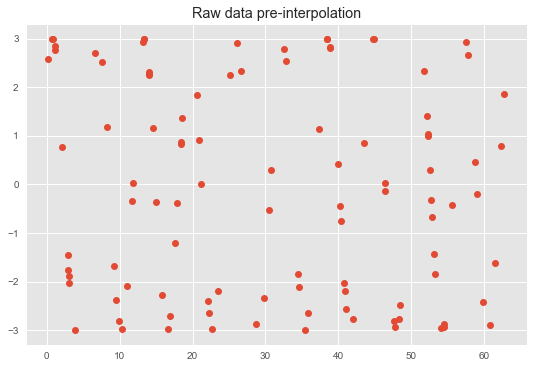

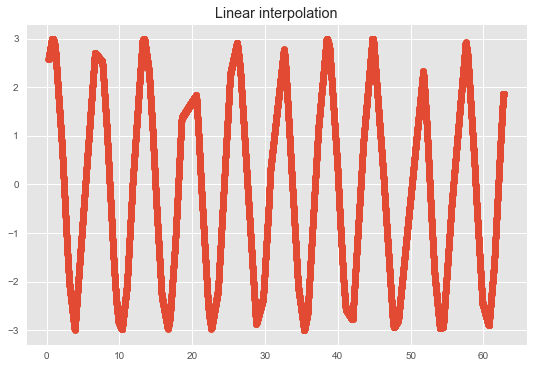

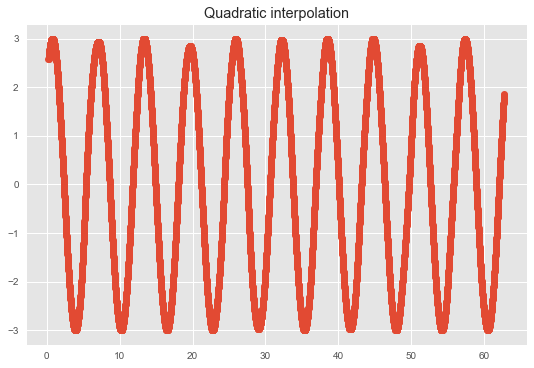

In [174]:
import matplotlib.pyplot as plt

num_periods = 10
num_reps = 10000
amp = 3
phase = np.pi / 4
x = np.linspace(0, 2*np.pi*num_periods, num=num_reps)
y = amp * np.sin(x + phase)

chosen_idx = np.random.choice(num_reps, size=100, replace=False)
data = pd.DataFrame(np.nan, index=x, columns=['raw'])
data.iloc[chosen_idx, 0] = y[chosen_idx]
fig1, ax1 = plt.subplots()
ax1.set_title('Raw data pre-interpolation')
data.raw.plot(marker='o')
data['lin_inter'] = data.raw.interpolate(method='index')
fig2, ax2 = plt.subplots()
ax2.set_title('Linear interpolation')
data.lin_inter.plot(marker='o')
data['quad_inter'] = data.raw.interpolate(method='quadratic')
fig3, ax3 = plt.subplots()
ax3.set_title('Quadratic interpolation')
data.quad_inter.plot(marker='o')

### 2

In [175]:
data = np.tile(np.arange(10)[:, np.newaxis], (1, 2))
df = pd.DataFrame(data)
df

,0,1
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [176]:
df.replace({0: 3}, {0: 99})

,0,1
0,0,0
1,1,1
2,2,2
3,99,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [177]:
df.replace({0: 3, 1: 1}, 99)

,0,1
0,0,0
1,1,99
2,2,2
3,99,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [178]:
df[0].replace(np.arange(3, 6), method='bfill')

0    0
1    1
2    2
3    6
4    6
5    6
6    6
7    7
8    8
9    9
Name: 0, dtype: int32

### 3

In [179]:
letters = ['a', 'b', 'c', 'd']
roman = ['i', 'ii', 'iii']
coor = ['x', 'y', 'z']
index = pd.MultiIndex.from_product((letters, roman, coor))
data = np.random.randint(20, size=(len(letters) * len(roman) * len(coor), 2))
df = pd.DataFrame(data, columns=['today', 'tomorrow'], index=index)
df

today  tomorrow
a i   x     19        17
      y     16        18
      z     13         6
  ii  x     16         0
      y      6        16
      z     17         1
  iii x      8        19
      y     17        12
      z      1        11
b i   x      9        14
      y      8        17
      z      2         7
  ii  x     18        16
      y     16         9
      z      6        17
  iii x      7         0
      y      0         4
      z      6         0
c i   x     10        15
      y      4        14
      z      7        18
  ii  x     19         3
      y      3         5
      z      7        13
  iii x     18         5
      y      3        13
      z      6         5
d i   x     14         3
      y      7         4
      z      8        17
  ii  x      0        17
      y      0         7
      z     16         9
  iii x      7        10
      y     17         6
      z     16        19

In [180]:
# Extract specific values - 1
df.loc['a', 'ii', 'z']

today       17
tomorrow     1
Name: (a, ii, z), dtype: int32

In [181]:
# Extract specific values - 2
df.xs(key=('a', 'ii', 'z'))

today       17
tomorrow     1
Name: (a, ii, z), dtype: int32

In [182]:
# Extract specific values - 2
idx = pd.IndexSlice
df.loc[idx['a', 'ii', 'z'], :]

today       17
tomorrow     1
Name: (a, ii, z), dtype: int32

In [183]:
# Extract slice - 1
idx = pd.IndexSlice
df.loc[idx[:, :, 'x'], :]

today  tomorrow
a i   x     19        17
  ii  x     16         0
  iii x      8        19
b i   x      9        14
  ii  x     18        16
  iii x      7         0
c i   x     10        15
  ii  x     19         3
  iii x     18         5
d i   x     14         3
  ii  x      0        17
  iii x      7        10

In [184]:
# Extract slice - 2
df.xs(key='x', level=2)

today  tomorrow
a i       19        17
  ii      16         0
  iii      8        19
b i        9        14
  ii      18        16
  iii      7         0
c i       10        15
  ii      19         3
  iii     18         5
d i       14         3
  ii       0        17
  iii      7        10

### 4

In [185]:
import zipfile

with zipfile.ZipFile(r'311_service_requests.zip') as zip:
    zip.extractall(path=r'.')

reqs = pd.read_csv(r'311_service_requests.csv')
reqs.head()

C:\Users\Hagai\Miniconda3\envs\general\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (9,40,41,42,43,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,0,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,TLC,Correspondence - Taxi and Limousine Commission,Taxi Compliment,Driver Compliment,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,19579718,01/11/2011 03:00:00 AM,NaN,DEP,Department of Environmental Protection,Lead,Lead Kit Request (Residential) (L10),NaN,10011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,2,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,TLC,Correspondence - Taxi and Limousine Commission,Taxi Compliment,Driver Compliment,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,19579917,01/11/2011 12:46:00 PM,NaN,DEP,Department of Environmental Protection,Lead,Lead Kit Request (Non-Residential) (L11),NaN,10128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,4,19580080,01/11/2011 05:03:00 PM,NaN,DEP,Department of Environmental Protection,Lead,Lead Kit Request (Residential) (L10),NaN,11208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [186]:
reqs.set_index(['Unnamed: 0', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', 'Bridge Highway Direction'], inplace=True)
reqs.head()

,,,,,,Unique Key,Created Date,Closed Date,Agency Name,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,...,Taxi Pick Up Location,Bridge Highway Name,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
Unnamed: 0,Agency,Complaint Type,Descriptor,Location Type,Bridge Highway Direction,,,,,,,,,,,,,,,,,,,,,
0,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19579718,01/11/2011 03:00:00 AM,NaN,Department of Environmental Protection,10011,226 WEST 20 STREET,WEST 20 STREET,7 AVENUE,8 AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEP,Lead,Lead Kit Request (Non-Residential) (L11),NaN,NaN,19579917,01/11/2011 12:46:00 PM,NaN,Department of Environmental Protection,10128,7 EAST 95 STREET,EAST 95 STREET,5 AVENUE,MADISON AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19580080,01/11/2011 05:03:00 PM,NaN,Department of Environmental Protection,11208,721 FOUNTAIN AVENUE,FOUNTAIN AVENUE,WORTMAN AVENUE,COZINE AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [187]:
reqs.index.set_names('num', level=0, inplace=True)
reqs.head()

,,,,,,Unique Key,Created Date,Closed Date,Agency Name,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,...,Taxi Pick Up Location,Bridge Highway Name,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
num,Agency,Complaint Type,Descriptor,Location Type,Bridge Highway Direction,,,,,,,,,,,,,,,,,,,,,
0,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19579718,01/11/2011 03:00:00 AM,NaN,Department of Environmental Protection,10011,226 WEST 20 STREET,WEST 20 STREET,7 AVENUE,8 AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEP,Lead,Lead Kit Request (Non-Residential) (L11),NaN,NaN,19579917,01/11/2011 12:46:00 PM,NaN,Department of Environmental Protection,10128,7 EAST 95 STREET,EAST 95 STREET,5 AVENUE,MADISON AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19580080,01/11/2011 05:03:00 PM,NaN,Department of Environmental Protection,11208,721 FOUNTAIN AVENUE,FOUNTAIN AVENUE,WORTMAN AVENUE,COZINE AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [188]:
# Different entries for each index
reqs.count()

Unique Key                        300000
Created Date                      300000
Closed Date                       258815
Agency Name                       300000
Incident Zip                      292510
Incident Address                  247648
Street Name                       247620
Cross Street 1                    247870
Cross Street 2                    247755
Intersection Street 1              27723
Intersection Street 2              27725
Address Type                      289396
City                              292703
Landmark                             287
Facility Type                      40574
Status                            299999
Due Date                          107631
Resolution Description            270293
Resolution Action Updated Date    286853
Community Board                   300000
Borough                           300000
X Coordinate (State Plane)        275201
Y Coordinate (State Plane)        275201
Park Facility Name                300000
Park Borough    

## _n_-Dimensional Containers

While technically a DataFrame is a two-dimensional container, in the next lesson we'll see why it can perform quite efficienty as a pseudo n-dimensional container. 

If you wish to have _true_ n-dimensional DataFrame-like data structures, you should use the `xarray` package and its `xr.DataArray` and `xr.Dataset` objects, which we'll discuss in the next lessons.

## String DataFrames

The raw data we have can sometimes come in the form of strings. Pandas support string DataFrames and allows for manipulation of these objects.

Note: I'm currently not discussing "bioinformatic sequences" of `ATGC` - these have a special `Seq` class in the Biopython package, which we'll mention later.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_str = pd.DataFrame(['a', 'b', 'c', 'D  ', 'EFG', 'hij', 'k', '', ' LMNOP', 'QRST', 'UV', ' wxy', 'z'],
                      columns=['alpha'])
df_str

,alpha
0,a
1,b
2,c
3,D
4,EFG
5,hij
6,k
7,
8,LMNOP
9,QRST


To access the varienty of string methods in pandas, use the `.str` attribute of a Series.

In [5]:
df_str.alpha.str.lower()

0         a
1         b
2         c
3         d
4       efg
5       hij
6         k
7          
8     lmnop
9      qrst
10       uv
11      wxy
12        z
Name: alpha, dtype: object

In [8]:
df_str.alpha.str.strip()  # remove whitespaces

0         a
1         b
2         c
3         D
4       EFG
5       hij
6         k
7          
8     LMNOP
9      QRST
10       UV
11      wxy
12        z
Name: alpha, dtype: object

When parsing `.csv` data, the column names can sometimes be unorderly, having whitespaces and different capitalization conventions. Here's an example of how to make them look alike:

In [9]:
# Assume we parsed this DataFrame from some third-party source
csv_df = pd.DataFrame([], columns=[' Name', 'Age ', ' Gender ', 'Is single', 'Has children', 'Num of Children'])
csv_df

,Name,Age,Gender,Is single,Has children,Num of Children


Due to the fact that a column of a DataFrame is a regular Index object, we can use our string methods to make it look better:

In [14]:
csv_df.columns = csv_df.columns.str.strip()\
                               .str.lower()\
                               .str.replace(' ', '_')
csv_df  # stripped of leading and trailing whitespaces, 
        # removed capital letters
        # and replaced spaces with underscores

,name,age,gender,is_single,has_children,num_of_children


We can get the first letter in each entry:

In [11]:
df_str.alpha.str.get(0)

0       a
1       b
2       c
3       D
4       E
5       h
6       k
7     NaN
8        
9       Q
10      U
11       
12      z
Name: alpha, dtype: object

You can also use regular expressions to extract patterns from each row of the Series. We'll discuss regular expressions, or regexes, in the second part of this lecture.

In the mean time, a summary of all the string-related methods in pandas can be found [here](http://pandas.pydata.org/pandas-docs/stable/text.html). They contain most of the Pythonic string-related operations.

Note: String operations aren't as fast as numerical computations since they're currently implemented mostly with Python in the backend, and not C.

## Pandas Concatenation

Similar to numpy arrays, Series and DataFrame objects can be concatenated as well. The indexes of the pandas objects is what usually makes this operation non-trivial.

While this discussion might not seem to you super important, it's actually more useful than you'd think. Thinking of our different sets of data in terms of a large database can sometimes be a good analogy.

A full tutorial on this manner can be found in the official pandas tutorial, right [here](https://pandas.pydata.org/pandas-docs/stable/merging.html).

In [16]:
ser1 = pd.Series(['a', 'b', 'c'], index=[1, 2, 3])
ser2 = pd.Series(['d', 'e', 'f'], index=[4, 5, 6])
pd.concat([ser1, ser2])  # row-wise (axis=0) by default

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

In [17]:
# This simple behavior can be achieved using the append method
ser1.append(ser2)

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

In [18]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[2, 3])
pd.concat([df1, df2])  # again, along the first axis

,let,LET
0,a,A
1,b,B
2,c,C
3,d,D


In [19]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let1', 'LET1'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let2', 'LET2'], index=[2, 3])
pd.concat([df1, df2])  # pandas can't make the column index compatible, so it resorts to columnar concat
# the same result is achieved by pd.concat([df1, df2], axis=1)

,LET1,LET2,let1,let2
0,A,NaN,a,NaN
1,B,NaN,b,NaN
2,NaN,C,NaN,c
3,NaN,D,NaN,d


If we wish to keep the integrity of the indices, we can use the `verify_integrity` keyword:

In [22]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[0, 2])
pd.concat([df1, df2], verify_integrity=True)

ValueError: Indexes have overlapping values: [0]

If we don't care about the indices, we can just ignore them:

In [23]:
pd.concat([df1, df2], ignore_index=True)  # creates a new index

,let,LET
0,a,A
1,b,B
2,c,C
3,d,D


We can also create a new MultiIndex if it makes more sense:

In [24]:
pd.concat([df1, df2], keys=['df1', 'df2'])  # "remembers" the origin of the data, super useful!

let LET
df1 0   a   A
    1   b   B
df2 0   c   C
    2   d   D

A real world example of concatenation is when we wish to join two datasets taken at different times. For example, if we conducted in day 1 measurements at times 8:00, 10:00, 14:00 and 16:00, but during day 2 we were a bit dizzy, and conducted the measurements at 8:00, 10:00, 13:00 and 16:30. On top of that, we recorded another parameter that we forget to measure at day 1.

The default concatenation behavior of pandas keeps all the data. In database terms (SQL people rejoice!) it's called an "outer join":

In [10]:
# Prepare mock data
times_day1 = pd.to_datetime(['08:00', '10:00', '14:00', '16:00'], format='%H:%M')
times_day2 = pd.to_datetime(['08:00', '10:00', '13:00', '16:30'], format='%H:%M')

temp_day1 = [36.6, 36.7, 37.0, 36.8]
temp_day2 = [35.9, 36.1, 36.5, 36.2]

humid_day1 = [30., 31., 30.4, 30.4]
humid_day2 = [32.2, 34.2, 30.9, 32.6]

light_day2 = [200, 130, 240, 210]

data_day1 = pd.DataFrame({'temp': temp_day1, 'humid': humid_day1}, index=times_day1)
data_day2 = pd.DataFrame({'temp': temp_day2, 'humid': humid_day2,
                          'light': light_day2}, index=times_day2)
data_day2

,humid,light,temp
1900-01-01 08:00:00,32.2,200,35.9
1900-01-01 10:00:00,34.2,130,36.1
1900-01-01 13:00:00,30.9,240,36.5
1900-01-01 16:30:00,32.6,210,36.2


In [12]:
# Outer join
pd.concat([data_day1, data_day2], join='outer')  # outer join is the default behavior  

,humid,light,temp
1900-01-01 08:00:00,30.0,NaN,36.6
1900-01-01 10:00:00,31.0,NaN,36.7
1900-01-01 14:00:00,30.4,NaN,37.0
1900-01-01 16:00:00,30.4,NaN,36.8
1900-01-01 08:00:00,32.2,200.0,35.9
1900-01-01 10:00:00,34.2,130.0,36.1
1900-01-01 13:00:00,30.9,240.0,36.5
1900-01-01 16:30:00,32.6,210.0,36.2


To take the intersection of the columns we have to use inner join. The intersection is all the columns that are common in all datasets.

In [14]:
# Inner join - the excess data column was dropped (index is still not unique)
pd.concat([data_day1, data_day2], join='inner')

,humid,temp
1900-01-01 08:00:00,30.0,36.6
1900-01-01 10:00:00,31.0,36.7
1900-01-01 14:00:00,30.4,37.0
1900-01-01 16:00:00,30.4,36.8
1900-01-01 08:00:00,32.2,35.9
1900-01-01 10:00:00,34.2,36.1
1900-01-01 13:00:00,30.9,36.5
1900-01-01 16:30:00,32.6,36.2


One can also specify the exact columns that should be the result of the join operation using the `columns` keyword. All in all, this basic functionality is easy to understand and allows for high flexibility. If you wish to conduct a more sophisticated join operation, you should use `pd.merge()`, as we'll show below.

Finally, joining on the columns will require the indices to be unique:

In [18]:
pd.concat([data_day1, data_day2], join='inner', axis='columns')

,humid,temp,humid,light,temp
1900-01-01 08:00:00,30.0,36.6,32.2,200,35.9
1900-01-01 10:00:00,31.0,36.7,34.2,130,36.1


This doesn't look so good. The columns are a mess and we're barely left with any data. The right operation for this job is a `pd.merge`.

Merging two DataFrames into one is done in the following manner:

In [24]:
times = pd.to_datetime(['08:00', '10:00', '14:00', '16:00'], format='%H:%M')

temp_day1 = [36.6, 36.7, 37.0, 36.8]
humid_day1 = [30., 31., 30.4, 30.4]

df_temp = pd.DataFrame({'temp': temp_day1}, index=times)
df_humid = pd.DataFrame({'humid': humid_day1}, index=times)

pd.merge(df_temp, df_humid, right_index=True, left_index=True)  # merge with indices

,temp,humid
1900-01-01 08:00:00,36.6,30.0
1900-01-01 10:00:00,36.7,31.0
1900-01-01 14:00:00,37.0,30.4
1900-01-01 16:00:00,36.8,30.4


In [25]:
# Slightly different data example
temp_day1 = [36.6, 36.7, 37.0, 36.8]
humid_day1 = [30., 31., 30.4, 30.4]

temp_day2 = [37.1, 36.6, 36.6, 36.7]

df_day1 = pd.DataFrame({'temp': temp_day1, 'humid': humid_day1}, index=times)
df_day2 = pd.DataFrame({'temp': temp_day2}, index=times)

df_day1

,humid,temp
1900-01-01 08:00:00,30.0,36.6
1900-01-01 10:00:00,31.0,36.7
1900-01-01 14:00:00,30.4,37.0
1900-01-01 16:00:00,30.4,36.8


In [32]:
# Merging (as a method, not a procedure)
df_day1.merge(df_day2, left_index=True, right_index=True)
# This merge "remembers" the origin of the data, the "suffixes" keyword allows us to determine the new suffix

,humid,temp_x,temp_y
1900-01-01 08:00:00,30.0,36.6,37.1
1900-01-01 10:00:00,31.0,36.7,36.6
1900-01-01 14:00:00,30.4,37.0,36.6
1900-01-01 16:00:00,30.4,36.8,36.7


In [34]:
# One more example, more similar to traditional databases
mouse_id = [511, 512, 513, 514]
meas1 = [67, 66, 89, 92]
meas2 = [45, 45, 65, 61]

data1 = pd.DataFrame({'id': mouse_id, 'blood_vol': meas1})
data2 = pd.DataFrame({'id': mouse_id, 'monocytes': meas2})
data1

,blood_vol,id
0,67,511
1,66,512
2,89,513
3,92,514


In [35]:
data1.merge(data2)  # merge identified that the only "key" connecting the two tables was the 'id' key

,blood_vol,id,monocytes
0,67,511,45
1,66,512,45
2,89,513,65
3,92,514,61


Database-like operation is a very broad topic in pandas, and it's another great example of why should you keep your data in a DataFrame.

If you feel like this join and merge operation might help you, don't hesitate to consult the official documents on this topic, linked [here](https://pandas.pydata.org/pandas-docs/stable/merging.html) (again).

## GroupBy

Yet another SQL-like feature that pandas posses is the group-by operation, sometimes known as "split-apply-combine".

In [38]:
# Mock data
subject = [100, 101, 102, 106, 108, 109]
dead = [True, True, False, True, False, False]
took_med = [False, True, True, False, False, True]
val1 = np.random.random(6)
val2 = np.random.random(6)
df = pd.DataFrame({'dead': dead, 'took_med': took_med,
                   'val1': val1, 'val2': val2}, index=subject)
df

,dead,took_med,val1,val2
100,True,False,0.441351,0.594263
101,True,True,0.493758,0.798671
102,False,True,0.425116,0.644434
106,True,False,0.348801,0.236457
108,False,False,0.991286,0.189593
109,False,True,0.074624,0.911298


The most sensible thing to do is to group by either the "dead" or the "took_med" column (or both). This is the "split" part.

In [40]:
grouped = df.groupby('dead')
grouped  # DataFrameGroupBy object - intermediate object ready to be evaluated

This intermediate object is an internal pandas representation which should allow it to run very fast computation the moment we want to actually _know_ something about these groups. Assuming we want the mean of `val1`, as long as we won't specifically write `grouped.mean()` pandas will do very little in terms of actual computation. It's called "lazy evaluation".

The intermediate object has some useful attributes:

In [41]:
grouped.groups

{False: Int64Index([102, 108, 109], dtype='int64'),
 True: Int64Index([100, 101, 106], dtype='int64')}

In [42]:
len(grouped)  # True and False

2

If we wish to run some actual processing, we have to use an aggregation function:

In [45]:
grouped.sum()

,took_med,val1,val2
dead,,,
False,2.0,1.491026,1.745325
True,1.0,1.283910,1.629391


In [46]:
grouped.mean()

,took_med,val1,val2
dead,,,
False,0.666667,0.497009,0.581775
True,0.333333,0.427970,0.543130


In [48]:
grouped.size()

dead
False    3
True     3
dtype: int64

If we just wish to see one of the groups, we can use `get_group()`:

In [47]:
grouped.get_group(True)

,took_med,val1,val2
100,False,0.441351,0.594263
101,True,0.493758,0.798671
106,False,0.348801,0.236457


We can also call several functions at once using the `.agg` attribute:

In [50]:
grouped.agg([np.sum, np.var])

took_med                val1                val2          
           sum       var       sum       var       sum       var
dead                                                            
False      2.0  0.333333  1.491026  0.213944  1.745325  0.133159
True       1.0  0.333333  1.283910  0.005387  1.629391  0.080982

GroupBy offers many more features, documented [online](http://pandas.pydata.org/pandas-docs/stable/groupby.html).

## Exercise

1. _Strings in pandas:_ 
    - Generate a 1000-length `pd.DataFrame` filled with 3-letter strings. Use the `string` module, and others, to generate it quickly.
    - Add a column indicating if the string in this row has a `z` in its 2nd character.
    - Add a third column swapping the case of the 3-letter string in these specific lines (`azI` to `AZi`). In the other lines it should remain uncapitalized.

2. _Concatenation:_
    - Create three DataFrames with random values and shapes of (10x2), (10x1), (15x3). Their index should be simple ordinal integers, and their column names should differ.
    - Concatenate these DFs over the second axis using pd.concat.
    - Concatenate these DFs over the second axis using pd.merge.

3. _GroupBy:_
    - Create a DataFrame with two columns, 10k entries in length. The first should be a "flag" column, having a value of either 0 or 1, randomly. The second should be A sine wave from 0 to 20pi, length of 10k. This simulates measuring a parameter from two distinct groups.
    - GroupBy the DataFrame, creating a GroupBy object.
    - Plot and overlay the two traces (of the two flags).
    - Use the `.rolling()` method to create a rolling average window of length 5 and overlay the result.


## Exercise solutions below...

In [10]:
# 1
import string
import numpy as np
import pandas as pd

# Generate the array
letters = list(string.ascii_lowercase)
size = 1000
num_of_letters = 3 
chosen = np.random.choice(letters, size*num_of_letters)
chosen = chosen.reshape((size, num_of_letters))
df = pd.DataFrame(chosen, columns=['a', 'b', 'c'])
df['letters'] = df.a.str.cat(df.b.str.cat(df.c))

# Filter
char = 'z'
df['no_z'] = df['letters'].str.find(char) != 1
df['swap'] = df['letters'].where(df['no_z'], other=df['letters'].str.upper())
df.head(20)

,a,b,c,let,z,swap
0,o,k,q,okq,True,okq
1,t,y,i,tyi,True,tyi
2,q,d,b,qdb,True,qdb
3,h,i,v,hiv,True,hiv
4,d,d,u,ddu,True,ddu
5,y,j,z,yjz,True,yjz
6,d,k,t,dkt,True,dkt
7,g,s,z,gsz,True,gsz
8,l,r,d,lrd,True,lrd
9,v,x,j,vxj,True,vxj


In [18]:
# 2
dfa = pd.DataFrame(np.random.random((10, 2)), columns=['a', 'b'])
dfb = pd.DataFrame(np.random.random((10, 1)), columns=['c'])
dfc = pd.DataFrame(np.random.random((15, 3)), columns=['d', 'e', 'f'])

# Using concat
print(pd.concat([dfa, dfb, dfc], axis=1))
# Using merge
pd.merge(pd.merge(dfa, dfb, how='outer', left_index=True, right_index=True), 
         dfc, how='outer', left_index=True, right_index=True)

           a         b         c         d         e         f
0   0.900669  0.280230  0.318374  0.807141  0.503972  0.725672
1   0.950723  0.982658  0.497995  0.433639  0.832532  0.022311
2   0.472416  0.559380  0.321904  0.876308  0.015207  0.923428
3   0.194426  0.494410  0.843525  0.052761  0.818829  0.199990
4   0.485229  0.899443  0.581080  0.061277  0.066091  0.825982
5   0.147794  0.280309  0.288444  0.338488  0.990080  0.672646
6   0.617450  0.786731  0.395389  0.360243  0.974382  0.547375
7   0.247248  0.933971  0.078926  0.734298  0.878901  0.938874
8   0.443867  0.522806  0.235858  0.617627  0.754874  0.710784
9   0.709414  0.084797  0.399524  0.576512  0.609701  0.360584
10       NaN       NaN       NaN  0.870390  0.843559  0.970103
11       NaN       NaN       NaN  0.783877  0.988565  0.621162
12       NaN       NaN       NaN  0.119107  0.131868  0.636999
13       NaN       NaN       NaN  0.649080  0.674764  0.330253
14       NaN       NaN       NaN  0.024170  0.063873  0

,a,b,c,d,e,f
0,0.900669,0.280230,0.318374,0.807141,0.503972,0.725672
1,0.950723,0.982658,0.497995,0.433639,0.832532,0.022311
2,0.472416,0.559380,0.321904,0.876308,0.015207,0.923428
3,0.194426,0.494410,0.843525,0.052761,0.818829,0.199990
4,0.485229,0.899443,0.581080,0.061277,0.066091,0.825982
5,0.147794,0.280309,0.288444,0.338488,0.990080,0.672646
6,0.617450,0.786731,0.395389,0.360243,0.974382,0.547375
7,0.247248,0.933971,0.078926,0.734298,0.878901,0.938874
8,0.443867,0.522806,0.235858,0.617627,0.754874,0.710784
9,0.709414,0.084797,0.399524,0.576512,0.609701,0.360584


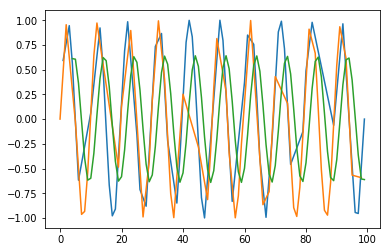

In [37]:
# 3
vals = np.array([0, 1])
needed = 100
stop = 20 * np.pi
chosen = np.random.choice(vals, needed)
df = pd.DataFrame({'flag': chosen, 'val': np.sin(np.linspace(start=0, stop=stop, num=needed))})

window_size = 5
grouped = df.groupby('flag')
grouped.val.plot()

df.val.rolling(window=window_size).mean().plot()

## IntervalIndex

Pandas has a __TON__ of features and small implementation details that are there to make your life simpler. A small example, just to make you look for these deep in the documentation, is an `IntervalIndex`.

`IntervalIndex` is a type of index, just like a `DatetimeIndex` that we've seen many times, or a simple integer index. This index is special because it contain a start and a stop "time", and values can be included or excluded in this range.

In [44]:
df = pd.DataFrame([0, 1, 2, 3], index=pd.IntervalIndex.from_breaks((0, 1, 2, 3, 4)),
                  columns=['data'])
df  # notice the index

,data
"(0, 1]",0
"(1, 2]",1
"(2, 3]",2
"(3, 4]",3


In [45]:
# Select a label on the edge of the index
df.loc[2]  # label-based, i.e. index-based and not value-based

data    1
Name: (1, 2], dtype: int64

In [46]:
df.loc[[1, 2]]

,data
"(0, 1]",0
"(1, 2]",1


In [47]:
# Select a label contained in the index
df.loc[1.5]

data    1
Name: (1, 2], dtype: int64

There are types of datasets that "demand" an `IntervalIndex`, 
in the sense that it's very natural to use them to represent the data. 
For example, if you sample data from an electrode every microsecond, 
then the measurement at time `t` represents the values in times `(t-us, t]`.

# Higher Dimensionality - `xarray`

Pandas is amazing, but has its limits. A `DataFrame` can be a multi-dimensional container when using a `MultiIndex`, but it's limited to a subset of uses in which another layer of indexing makes sense.

In many occasions, however, our data is truly high-dimensional. A simple case could be electrophysiological recordings, or calcium traces. In these cases we have several indices (some can be categorical), like "Sex", "AnimalID", "Date", "TypeOfExperiment" and perhaps a few more. But the data itself is a vector of numbers representing voltage or fluorescence. Having this data in a DataFrame seems a bit "off" - what are the columns on this DF? Is each column a voltage measurement? Or if each column is a measurement, how do you deal with the indices? We can use nested columns (`MultiIndex` the columns), but it's not a very modular approach.

This is a classic example where pandas DF "fail", and indeed pandas used to have a higher-dimensionality container named `Panel`. However, late 2016 pandas devs deprecated it, publicly announcing that they intend to drop support for `Panel`s sometime in the future, and whoever needs a higher-dimensionality container should use `xarray`.

Thus, in essence `xarray` is a labeled n-dimensional array. Just like a DataFrame is a labeled 2D array, i.e. with names to its axes rather than numbers, in `xarray` each dimension has a name (`time`, `temp`, `voltage`) and its indices ("coordinates") can also have labels (like a timestamp, for example). In addition, each `xarray` object also has metadata attached to it, in which we can write details that do not fit a columnar structure (experimenter name, hardware and software used for acquisition, etc.).

## DataArray

In [28]:
import numpy as np
import xarray as xr


da = xr.DataArray(np.random.random((10, 2)))
da

<xarray.DataArray (dim_0: 10, dim_1: 2)>
array([[0.388372, 0.322975],
       [0.66755 , 0.387172],
       [0.322697, 0.402664],
       [0.689127, 0.766018],
       [0.932728, 0.217705],
       [0.006257, 0.254902],
       [0.717271, 0.289948],
       [0.530961, 0.846113],
       [0.326677, 0.698273],
       [0.99913 , 0.47459 ]])
Dimensions without coordinates: dim_0, dim_1

The basic building block of `xarray` is a DataArray, an n-dimensional counter part of a pandas' Series. It has two dimensions, just like the numpy array that its based upon. We didn't specify names for these dimensions, so currently they're called `dim_0` and `dim_1`. We also didn't specify coordinates (indices), so the printout doesn't report of any coordinates for the data.

In [29]:
da.values  # just like pandas

array([[0.38837163, 0.32297529],
       [0.66755029, 0.3871716 ],
       [0.32269693, 0.40266436],
       [0.689127  , 0.76601818],
       [0.93272751, 0.21770453],
       [0.00625731, 0.25490163],
       [0.717271  , 0.28994843],
       [0.53096149, 0.84611271],
       [0.32667711, 0.69827316],
       [0.99912973, 0.47458991]])

In [30]:
da.coords

Coordinates:
    *empty*

In [31]:
da.dims

('dim_0', 'dim_1')

In [32]:
da.attrs

OrderedDict()

We'll add coordinates and dimension names and see how indexing works:

In [33]:
dims = ('time', 'repetition')
coords = {'time': np.linspace(0, 1, num=10),
          'repetition': np.arange(2)}
da2 = xr.DataArray(np.random.random((10, 2)), dims=dims, coords=coords)
da2

<xarray.DataArray (time: 10, repetition: 2)>
array([[0.992325, 0.864066],
       [0.779553, 0.451607],
       [0.482595, 0.01895 ],
       [0.1183  , 0.929402],
       [0.956396, 0.277636],
       [0.065881, 0.774456],
       [0.229689, 0.594903],
       [0.406534, 0.428065],
       [0.909886, 0.172933],
       [0.898107, 0.748419]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 ...
  * repetition  (repetition) int32 0 1

In [34]:
da2[[0, 1]]  # positional
da2.loc[0.1:0.3, 1]  # rows 1-2 in the second column

<xarray.DataArray (time: 2)>
array([0.451607, 0.01895 ])
Coordinates:
  * time        (time) float64 0.1111 0.2222
    repetition  int32 1

In [35]:
da2.isel(time=slice(3, 7))  # dimension name and integer label (sel = select)

<xarray.DataArray (time: 4, repetition: 2)>
array([[0.1183  , 0.929402],
       [0.956396, 0.277636],
       [0.065881, 0.774456],
       [0.229689, 0.594903]])
Coordinates:
  * time        (time) float64 0.3333 0.4444 0.5556 0.6667
  * repetition  (repetition) int32 0 1

In [36]:
da2.sel(repetition=[0])  # dimension name and coordinate label

<xarray.DataArray (time: 10, repetition: 1)>
array([[0.992325],
       [0.779553],
       [0.482595],
       [0.1183  ],
       [0.956396],
       [0.065881],
       [0.229689],
       [0.406534],
       [0.909886],
       [0.898107]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 ...
  * repetition  (repetition) int32 0

Other operations on DataArrays, such as computations, grouping and such, are done very similarly to DataFrames and numpy arrays.

## Dataset

A Dataset is to a DataArray what a DataFrame is to a Series. In other words, it's a collection of DataArrays that share coordinates.

In [37]:
da2  # a reminder. We notice that this could've been a DataFrame as well

<xarray.DataArray (time: 10, repetition: 2)>
array([[0.992325, 0.864066],
       [0.779553, 0.451607],
       [0.482595, 0.01895 ],
       [0.1183  , 0.929402],
       [0.956396, 0.277636],
       [0.065881, 0.774456],
       [0.229689, 0.594903],
       [0.406534, 0.428065],
       [0.909886, 0.172933],
       [0.898107, 0.748419]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 ...
  * repetition  (repetition) int32 0 1

In [45]:
ds = xr.Dataset({'ephys': da2,
                 'calcium': ('time', np.random.random(10))},
                attrs={'AnimalD': 701,
                       'ExperimentType': 'double',
                       'Sex': 'Male'})
ds

<xarray.Dataset>
Dimensions:     (repetition: 2, time: 10)
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 ...
  * repetition  (repetition) int32 0 1
Data variables:
    ephys       (time, repetition) float64 0.9923 0.8641 0.7796 0.4516 ...
    calcium     (time) float64 0.8935 0.2125 0.4837 0.4627 0.8965 0.5443 ...
Attributes:
    AnimalD:         701
    ExperimentType:  double
    Sex:             Male

In [43]:
ds['num_of_trials']  # individual DataArrays can be dissimilar in shape

<xarray.DataArray 'num_of_trials' ()>
array(4)

## Exercise

You're measuring the state of neurons in a rat's brain over time using a multi-electrode array surgically inserted into the rat's skull. The experiment is 5 seconds long, and after 2 seconds a short bright light is flashed at the animal. After 30 seconds the experiment is replicated, for a total of 10 repetitions. The relevant parameters are the following:
- Rat ID.
- Room temp.
- Room humidity.
- Experimenter name.
- Rat gender.
- Measured voltage (64 electrode, 50k samples representing 5 seconds).
- Stimulus index (1 when the flash of light occurred).
- Repetition number.

Mock data and model it. You'll use this model for your homework as well, where we will expand and work with it further, so try to build good foundations.

### No exercise solution due to HW assignment